In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [64]:
df=pd.read_csv('Keylogger_Detection.csv')
df.head(3)

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [5]:
df.dtypes

Unnamed: 0           int64
Flow ID             object
 Source IP          object
 Source Port       float64
 Destination IP     object
                    ...   
Idle Mean          float64
 Idle Std          float64
 Idle Max          float64
 Idle Min          float64
Class               object
Length: 86, dtype: object

In [46]:
Class_df = df["Class"]
Class_df.value_counts()

Class
Benign       308813
Keylogger    214804
Name: count, dtype: int64

In [50]:
df_proc = df.select_dtypes(include=[np.number])
df_proc = df_proc.join(Class_df)

In [51]:
df_proc.drop(['Unnamed: 0', ' Fwd Header Length.1'], axis=1, inplace=True)

In [9]:
print(df_proc.isna().sum().sum())
df_proc=df_proc.dropna()


879


In [10]:
df_proc["label"]=df_proc["Class"]
df_proc.loc[df_proc.label == "Benign", 'label'] = 0
df_proc.loc[df_proc.label == "Keylogger", 'label'] = 1
df_proc.drop('Class', axis=1, inplace=True)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
73223,53628.0,80.0,6.0,30055044.0,5.0,5.0,554.0,2215.0,554.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
240442,62362.0,53.0,17.0,31077.0,1.0,1.0,32.0,48.0,32.0,32.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
313839,41267.0,80.0,6.0,26917372.0,2.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
474175,51693.0,53.0,17.0,48897.0,1.0,1.0,33.0,107.0,33.0,33.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
231347,40888.0,80.0,6.0,10512802.0,8.0,15.0,364.0,16380.0,364.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


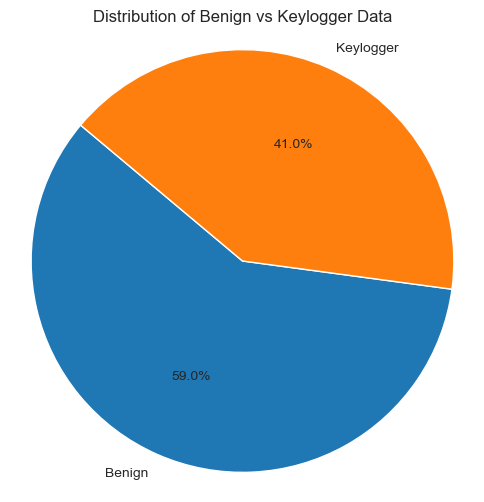

In [12]:
label_counts = df_proc.groupby('label').size()

label_counts.index = label_counts.index.map({0: 'Benign', 1: 'Keylogger'})

plt.figure(figsize = (6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle = 140)
plt.title('Distribution of Benign vs Keylogger Data')
plt.axis('equal')

plt.show()

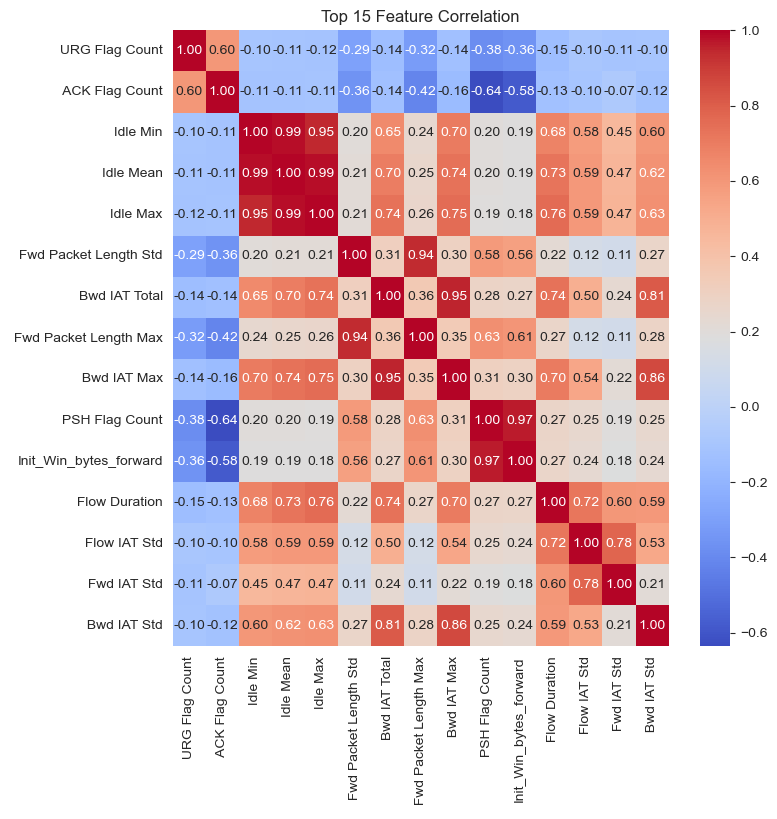

In [15]:
correlation = df_proc.corr()['label'].drop('label')
top_features = correlation.abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(8,8))
sns.heatmap(df_proc[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Top 15 Feature Correlation")
plt.show()

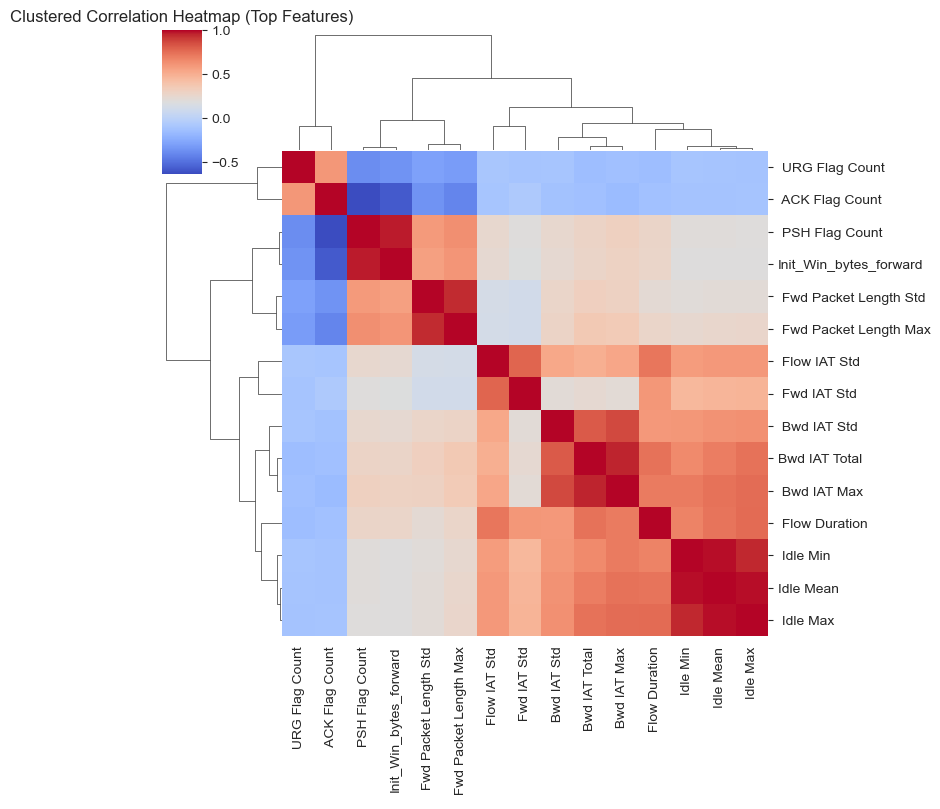

In [16]:
sns.clustermap(df_proc[top_features].corr(), cmap='coolwarm', figsize=(8,8))
plt.title("Clustered Correlation Heatmap (Top Features)")
plt.show()

In [18]:
for col in df_proc.iloc[:, :-1].columns:
    if df_proc[col].min()==df_proc[col].max():
            df_proc.drop(col, axis=1, inplace=True)

df_proc

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,34451.0,443.0,6.0,12140931.0,9.0,6.0,334.0,3664.0,208.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,53892.0,443.0,6.0,418882.0,102.0,203.0,829.0,279509.0,517.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,443.0,50750.0,6.0,45.0,2.0,0.0,55.0,0.0,55.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,23025.0,53.0,17.0,541699.0,1.0,1.0,39.0,225.0,39.0,39.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,52602.0,443.0,6.0,7310795.0,3.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,52373.0,80.0,6.0,589453.0,5.0,3.0,2924.0,121.0,1460.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
523613,2522.0,53.0,17.0,216310.0,1.0,1.0,37.0,74.0,37.0,37.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
523614,60995.0,80.0,6.0,5215688.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
523615,52724.0,443.0,6.0,223370.0,16.0,11.0,11275.0,1187.0,1368.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std())

for i in df_proc.iloc[:, :-1].columns:
    standardize (df_proc,i)

df_proc.head(10)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,-0.210447,-0.368579,-0.468868,0.042412,-0.004811,-0.036722,-0.013233,-0.038629,-0.021233,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
1,0.828487,-0.368579,-0.468868,-0.465677,0.945480,0.575336,-0.004001,0.556642,0.815442,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
2,-2.027848,2.839488,-0.468868,-0.483831,-0.076338,-0.055364,-0.018437,-0.046536,-0.435509,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
3,-0.821057,-0.393449,2.036972,-0.460353,-0.086556,-0.052257,-0.018736,-0.046050,-0.478832,0.522899,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
4,0.759549,-0.368579,-0.468868,-0.166949,-0.066120,-0.055364,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004135,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
5,1.027980,-0.368579,-0.468868,-0.483499,-0.076338,-0.055364,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,1
6,-2.027848,2.019600,-0.468868,-0.483735,-0.086556,-0.052257,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,1
7,0.318132,-0.368579,-0.468868,2.063655,-0.045683,-0.036722,0.008439,-0.043993,1.440918,-0.212203,...,0.004137,-0.054223,-0.063066,-0.066458,-0.036581,3.583537,-0.121636,3.366026,3.703864,1
8,0.486095,-0.368579,-0.468868,0.324113,-0.035465,-0.042936,-0.008869,-0.046208,0.815442,-0.212203,...,0.004135,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0
9,0.837519,-0.368579,-0.468868,-0.481682,-0.086556,-0.052257,-0.019463,-0.046536,-0.584432,-0.212203,...,0.004137,-0.183877,-0.063066,-0.175005,-0.173854,-0.290551,-0.121636,-0.296481,-0.277622,0


In [21]:
target=['label']
features = [c for c in df_proc.columns if c!="label"]

In [22]:
X = df_proc[features].values
y = df_proc[target].values

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((523595, 67), (523595, 1))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((418876, 67), (104719, 67), (418876, 1), (104719, 1))

In [26]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train.ravel())

y_pred = lr.predict(X_test)

auc = roc_auc_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Logistic Regression - AUC: {:.3f}, Accuracy: {:.3f}".format(auc, acc))

Logistic Regression - AUC: 0.527, Accuracy: 0.599


In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print("KNN - AUC: {:.3f}, Accuracy: {:.3f}".format(roc_auc_score(y_test, y_pred), accuracy_score(y_test, y_pred)))

KNN - AUC: 0.845, Accuracy: 0.851


In [32]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)


rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [33]:
y_pred=rf.predict(X_test)

AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Keylogger"]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

AUC: 0.974
Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98     61772
   Keylogger       0.98      0.96      0.97     42947

    accuracy                           0.98    104719
   macro avg       0.98      0.97      0.97    104719
weighted avg       0.98      0.98      0.98    104719

Confusion Matrix:
[[60813   959]
 [ 1577 41370]]


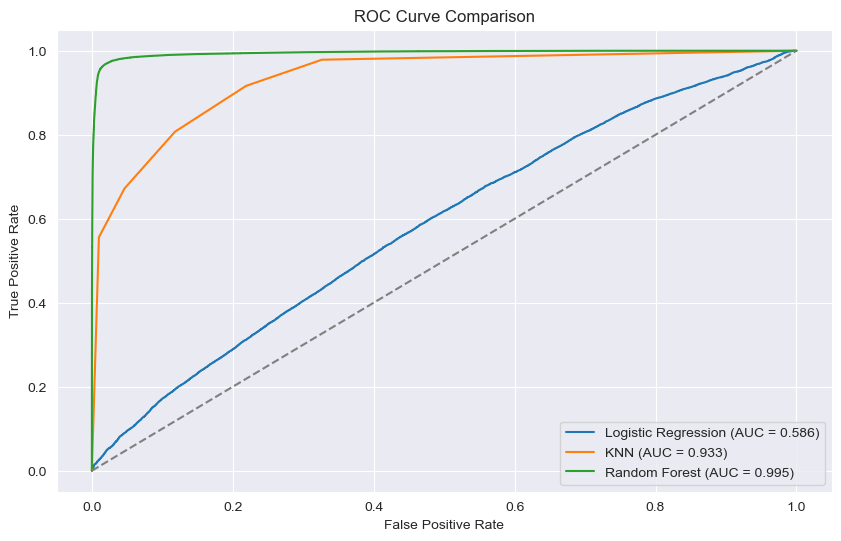

In [38]:
plt.figure(figsize=(10, 6))

fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc(fpr, tpr):.3f})')

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc(fpr, tpr):.3f})')

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


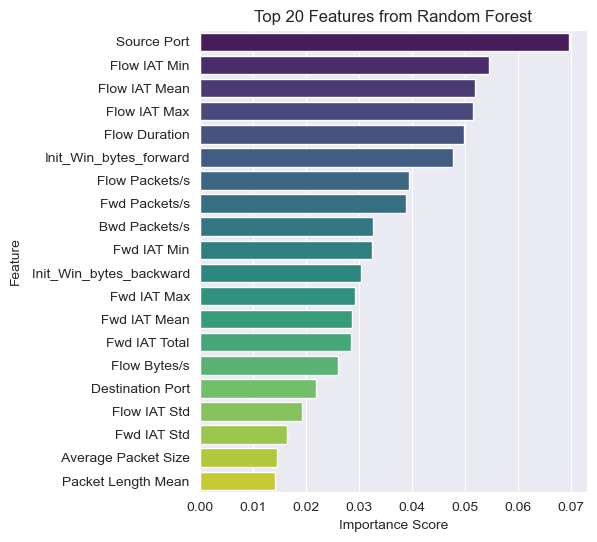

In [26]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top20_indices = indices[:20]

plt.figure(figsize=(5,6))
sns.barplot(x=importances[top20_indices], y=np.array(features)[top20_indices], palette="viridis")
plt.title("Top 20 Features from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [60]:
trained_feature_columns = features

with open("trained_features.pkl", "wb") as f:
    pickle.dump(trained_feature_columns, f)

In [61]:
df_wild = pd.read_csv("withinbound.pcap_Flow.csv")

df_wild = df_wild.select_dtypes(include=[np.number]) ##excluding the target

df_wild = df_wild.dropna()

for col in df_wild.iloc[:, :-1].columns:
    if df_wild[col].min()==df_wild[col].max():
        df_wild.drop(col, axis=1, inplace=True)

for i in df_wild.iloc[:, :-1].columns:
    standardize(df_wild, i)

with open("trained_features.pkl", "rb") as f:
    trained_feature_columns = pickle.load(f)

for col in trained_feature_columns:
    if col not in df_wild.columns:
        df_wild[col] = 0

df_wild = df_wild[trained_feature_columns]

X_wild = df_wild.values.astype(np.float32)

pred_rf = rf.predict(X_wild).astype(int)

prob_rf = rf.predict_proba(X_wild)[:, 1]

df_wild["RF_Prediction"] = pred_rf

df_wild["RF_Probability"] = prob_rf

df_wild


,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,RF_Prediction,RF_Probability
0,-1.118789,0.889328,0,3.328140,1.808230,1.681346,1.057053,-0.647755,-0.516588,3.328201,...,3.328201,3.328201,3.328201,3.328201,3.328201,3.328201,3.328201,10190385.0,1,0.520000
1,1.034944,-1.037749,0,-0.272526,0.688849,0.343132,0.846032,1.034857,1.030930,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.370000
2,-0.848575,0.889431,0,-0.283462,-0.990221,-0.995082,-1.036275,-0.926898,-0.944832,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.451060
3,1.034978,-1.037749,0,-0.268188,0.688849,0.789203,0.846032,1.034857,1.030930,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.400000
4,-0.848575,0.889465,0,-0.283476,-0.990221,-0.995082,-1.036275,-0.926898,-0.944832,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.451060
5,1.035011,-1.037749,0,-0.272209,0.688849,0.789203,0.854473,1.034857,1.030930,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.390000
6,-0.848575,0.889499,0,-0.282692,-0.990221,-0.995082,-1.036275,-0.926898,-0.944832,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,1,0.533392
7,1.035045,-1.037749,0,-0.270090,0.688849,0.789203,0.871354,1.034857,1.030930,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.400000
8,-0.848575,0.889533,0,-0.283207,-0.990221,-0.995082,-1.036275,-0.926898,-0.944832,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,1,0.533392
9,1.035078,-1.037749,0,-0.272654,0.688849,0.789203,0.871354,1.034857,1.030930,-0.277350,...,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,-0.277350,0.0,0,0.390000


In [62]:
overall_confidence = df_wild["RF_Probability"].mean()
print("Overall confidence that the process is a keylogger:", overall_confidence)

Overall confidence that the process is a keylogger: 0.4416172068455201
